# Coursework 2 A

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework2.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the EMNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

['inputs', 'targets']
['inputs', 'targets']


In [3]:
# save and present the data
save_stats= {}
def save_and_present(experiment, stats, parameter):

    np.savetxt(experiment +'.csv', stats, delimiter=',')

    error_valid= stats[1:, keys['error(valid)']]
    error_train= stats[1:, keys['error(train)']]
    acc_valid = stats[1:, keys['acc(valid)']]

    file = open(experiment+'.txt','w')
    overfitting = error_valid-error_train
    file.write('Experiment '+experiment+' best acc at Epoch={} by parameter={}\n'.
          format(np.argmax(acc_valid)+1, parameter))
    file.write('error(train)= {}, error(valid)={}, \n error gap = {},  acc(valid)={}\n'.
          format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
    file.write('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
          format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))
    print('Experiment '+experiment+' best acc at Epoch={} by parameter={}\n'.
          format(np.argmax(acc_valid)+1, parameter))
    print('error(train)= {}, error(valid)={}, \n error gap = {},  acc(valid)={}\n'.
          format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
    print('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
          format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))


## Perform baseline experiments
There are a lot things that could be explored including:
1. hidden unit activation functions, 
2. network architectures, 
3. training hyperparameters, 
4. **regularisation and dropout.   **

You cannot explore everything and is best to carefully investigate a few things in depth.

In [7]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.03
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

experiment = 'Relu_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, 'GradientDescent' )

save_stats[experiment] = stats

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 4.4s to complete
    error(train)=1.24e+00, acc(train)=6.50e-01, error(valid)=1.25e+00, acc(valid)=6.46e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 4.7s to complete
    error(train)=1.02e+00, acc(train)=7.10e-01, error(valid)=1.03e+00, acc(valid)=7.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

### Regularisation
L2 Penalty

In [8]:
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser
from mlp.penalty import L1Penalty, L2Penalty

# to ensure reproducibility of results
rng.seed(seed)
#################################################################################################################
#setup hyperparameters
for experiment, penalty in zip(['Relu_L2Penal_1e-4_x2','Relu_L2Penal_1e-3_x2'], [1e-4, 1e-3]):
    
    weights_penalty = L2Penalty(penalty)
    learning_rate = 0.03
    num_epochs = 100
    stats_interval = 1
    input_dim, output_dim, hidden_dim = 784, 47, 256

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty)
    ])

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    fig_1.savefig(experiment +'_error.pdf'.format(penalty))
    fig_2.savefig(experiment +'_accuracy.pdf'.format(penalty))

    save_and_present(experiment, stats, penalty)

    save_stats[experiment] = stats

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 5.8s to complete
    error(train)=1.25e+00, acc(train)=6.51e-01, error(valid)=1.26e+00, acc(valid)=6.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 5.2s to complete
    error(train)=1.01e+00, acc(train)=7.13e-01, error(valid)=1.02e+00, acc(valid)=7.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 5.2s to complete
    error(train)=8.68e-01, acc(train)=7.50e-01, error(valid)=8.83e-01, acc(valid)=7.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 5.7s to complete
    error(train)=7.78e-01, acc(train)=7.69e-01, error(valid)=7.98e-01, acc(valid)=7.62e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 5.1s to complete
    error(train)=7.12e-01, acc(train)=7.85e-01, error(valid)=7.36e-01, acc(valid)=7.78e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

### Dropout with  larger hidden units

In [12]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import DropoutLayer, RadialBasisFunctionLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.03
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256
##########################################################
# Use p = 0.5 in hidden layers and 0.8 in the input layer.
incl_prob_0 =0.8
incl_prob = 0.5
hidden_dim = int(hidden_dim/incl_prob)
##########################################################
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob_0),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

experiment = 'Drop_relu_2xhidden_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, 'Momentum' )

save_stats[experiment] = stats

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 10.5s to complete
    error(train)=3.37e+00, acc(train)=3.20e-01, error(valid)=3.37e+00, acc(valid)=3.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 10.8s to complete
    error(train)=2.05e+00, acc(train)=5.07e-01, error(valid)=2.05e+00, acc(valid)=5.05e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 9.4s to complete
    error(train)=1.61e+00, acc(train)=5.73e-01, error(valid)=1.61e+00, acc(valid)=5.71e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

### Drop out with higher momentum to speed up learning

In [ ]:
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import DropoutLayer, RadialBasisFunctionLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule, MomentumLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)

####################################################################################################################
for mom_coeff, experiment in zip([0.9, 0.99], ['Dropout_mom_0.9', 'Dropout_mom_0.99']):
    
    #setup hyperparameters
    learning_rate = 0.03
    num_epochs = 100
    stats_interval = 1
    # Set a higher hidden_dim for dropout
    input_dim, output_dim, hidden_dim = 784, 47, 256
    incl_prob_0 =0.8
    incl_prob = 0.5

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
        DropoutLayer(rng, incl_prob_0),
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    # Use a momentom learning rule
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)

    #return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
    fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

    save_and_present(experiment, stats, mom_coeff)

    save_stats[experiment] = stats
######################################################################################################################

### Drop out with larger hidden units and higher momentum

In [ ]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import DropoutLayer, RadialBasisFunctionLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)

#setup hyperparameters
learning_rate = 0.03
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256
##########################################################
# Use p = 0.5 in hidden layers and 0.8 in the input layer.
incl_prob_0 =0.8
incl_prob = 0.5
# n/p
hidden_dim = int(hidden_dim/incl_prob)
mom_coeff = 0.99
##########################################################
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob_0),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)

experiment = 'Drop_relu_2xhidden_mom_0.99_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, 'Momentum' )

save_stats[experiment] = stats

### Plot the data

In [ ]:
# Plot comparison
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
######################################################################################################
color = ['b', 'yellow', 'g', 'r', 'y', 'm', 'gray',] 
experiments = (['Relu_x2', 'Drop_relu_2xhidden_x2', 'Relu_L2Penal_1e-4_x2',
                'Relu_L2Penal_1e-3_x2','Dropout_mom_0.9', 'Dropout_mom_0.99', 'Drop_relu_2xhidden_mom_0.99_x2']



# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(12 , 8))
ax_1 = fig_1.add_subplot(111)

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(12, 8))
ax_2 = fig_2.add_subplot(111)

for i, experiment in enumerate(experiments):
    s = save_stats[experiment] 
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval, 
              s[1:, keys[k]], label=str(experiments[i]+' '+k),color=color[i],linewidth=0.8)
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval, 
              s[1:, keys[k]], label=str(experiments[i]+' '+k),color=color[i],linewidth=0.8)

ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Error evolution of regularisation/dropout over training',fontsize=18)

ax_2.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Accuracy evolution of regularisation/dropout over training',fontsize=18)

fig_1.savefig('Error_regularisation_dropout.pdf',bbox_inches = "tight")
fig_2.savefig('Accuracy_regularisation_dropout.pdf',bbox_inches = "tight" )

## Learning rule
Here we set the num_epochs = 50, and set the learning_rate=0.001, as these learning rules learns much faster.
If a higher learning_rate is provided, learning will diverge.


### RMSProp


In [6]:
%load_ext autoreload
%autoreload 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import RMSPropLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 50
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = RMSPropLearningRule(learning_rate=learning_rate,)

experiment = 'RMSProp_Relu_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 16.4s to complete
    error(train)=5.33e-01, acc(train)=8.23e-01, error(valid)=5.88e-01, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 15.0s to complete
    error(train)=4.15e-01, acc(train)=8.54e-01, error(valid)=5.07e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 15.3s to complete
    error(train)=3.45e-01, acc(train)=8.78e-01, error(valid)=4.65e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 15.6s to complete
    error(train)=3.09e-01, acc(train)=8.87e-01, error(valid)=4.85e-01, acc(valid)=8.48e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 15.4s to complete
    error(train)=3.07e-01, acc(train)=8.85e-01, error(valid)=5.10e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 14.4s to complete
    error(train)=2.81e-01, acc(train)=8.95e-01, error(valid)=5.21e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 13.7s to complete
    error(train)=2.52e-01, acc(train)=9.05e-01, error(valid)=5.30e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 15.3s to complete
    error(train)=2.36e-01, acc(train)=9.11e-01, error(valid)=5.65e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 16.0s to complete
    error(train)=2.33e-01, acc(train)=9.14e-01, error(valid)=5.80e-01, acc(valid)=8.48e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

### Adam learning rules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 7.5s to complete
    error(train)=6.61e-01, acc(train)=7.92e-01, error(valid)=6.90e-01, acc(valid)=7.85e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 6.8s to complete
    error(train)=5.64e-01, acc(train)=8.17e-01, error(valid)=6.11e-01, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 6.4s to complete
    error(train)=5.01e-01, acc(train)=8.34e-01, error(valid)=5.64e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 6.6s to complete
    error(train)=4.67e-01, acc(train)=8.43e-01, error(valid)=5.44e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 6.8s to complete
    error(train)=4.38e-01, acc(train)=8.52e-01, error(valid)=5.33e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 7.1s to complete
    error(train)=4.25e-01, acc(train)=8.55e-01, error(valid)=5.31e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 7.7s to complete
    error(train)=4.10e-01, acc(train)=8.58e-01, error(valid)=5.32e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 8.4s to complete
    error(train)=3.90e-01, acc(train)=8.65e-01, error(valid)=5.19e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 7.7s to complete
    error(train)=3.81e-01, acc(train)=8.68e-01, error(valid)=5.20e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 7.9s to complete
    error(train)=3.68e-01, acc(train)=8.70e-01, error(valid)=5.17e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 7.8s to complete
    error(train)=3.55e-01, acc(train)=8.73e-01, error(valid)=5.16e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 7.9s to complete
    error(train)=3.47e-01, acc(train)=8.77e-01, error(valid)=5.18e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 8.2s to complete
    error(train)=3.33e-01, acc(train)=8.80e-01, error(valid)=5.15e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 8.0s to complete
    error(train)=3.40e-01, acc(train)=8.78e-01, error(valid)=5.34e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 8.0s to complete
    error(train)=3.18e-01, acc(train)=8.86e-01, error(valid)=5.23e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 8.0s to complete
    error(train)=3.12e-01, acc(train)=8.87e-01, error(valid)=5.27e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 8.0s to complete
    error(train)=3.14e-01, acc(train)=8.86e-01, error(valid)=5.37e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 8.0s to complete
    error(train)=3.10e-01, acc(train)=8.88e-01, error(valid)=5.46e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 8.1s to complete
    error(train)=2.94e-01, acc(train)=8.93e-01, error(valid)=5.35e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 8.3s to complete
    error(train)=2.96e-01, acc(train)=8.91e-01, error(valid)=5.55e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 8.4s to complete
    error(train)=3.02e-01, acc(train)=8.88e-01, error(valid)=5.62e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 8.3s to complete
    error(train)=2.80e-01, acc(train)=8.97e-01, error(valid)=5.61e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 8.0s to complete
    error(train)=2.84e-01, acc(train)=8.95e-01, error(valid)=5.75e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 8.0s to complete
    error(train)=2.72e-01, acc(train)=8.99e-01, error(valid)=5.72e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 8.1s to complete
    error(train)=2.71e-01, acc(train)=8.98e-01, error(valid)=5.73e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 8.1s to complete
    error(train)=2.66e-01, acc(train)=9.01e-01, error(valid)=5.84e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 8.4s to complete
    error(train)=2.63e-01, acc(train)=9.00e-01, error(valid)=5.88e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 8.2s to complete
    error(train)=2.63e-01, acc(train)=9.02e-01, error(valid)=6.01e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 8.2s to complete
    error(train)=2.51e-01, acc(train)=9.06e-01, error(valid)=6.00e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 8.2s to complete
    error(train)=2.51e-01, acc(train)=9.05e-01, error(valid)=6.03e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 8.2s to complete
    error(train)=2.53e-01, acc(train)=9.04e-01, error(valid)=6.25e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 8.2s to complete
    error(train)=2.36e-01, acc(train)=9.11e-01, error(valid)=6.17e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 8.6s to complete
    error(train)=2.46e-01, acc(train)=9.06e-01, error(valid)=6.31e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 8.4s to complete
    error(train)=2.42e-01, acc(train)=9.08e-01, error(valid)=6.31e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 8.2s to complete
    error(train)=2.34e-01, acc(train)=9.11e-01, error(valid)=6.44e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 8.3s to complete
    error(train)=2.45e-01, acc(train)=9.03e-01, error(valid)=6.69e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 8.3s to complete
    error(train)=2.29e-01, acc(train)=9.11e-01, error(valid)=6.51e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 8.4s to complete
    error(train)=2.36e-01, acc(train)=9.09e-01, error(valid)=6.70e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 8.5s to complete
    error(train)=2.22e-01, acc(train)=9.15e-01, error(valid)=6.70e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 8.6s to complete
    error(train)=2.27e-01, acc(train)=9.10e-01, error(valid)=6.79e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 8.3s to complete
    error(train)=2.25e-01, acc(train)=9.12e-01, error(valid)=6.87e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 8.4s to complete
    error(train)=2.19e-01, acc(train)=9.15e-01, error(valid)=6.93e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 8.3s to complete
    error(train)=2.28e-01, acc(train)=9.10e-01, error(valid)=7.15e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 8.5s to complete
    error(train)=2.17e-01, acc(train)=9.14e-01, error(valid)=7.12e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 8.7s to complete
    error(train)=2.20e-01, acc(train)=9.15e-01, error(valid)=7.24e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 8.6s to complete
    error(train)=2.15e-01, acc(train)=9.16e-01, error(valid)=7.29e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 8.4s to complete
    error(train)=2.09e-01, acc(train)=9.18e-01, error(valid)=7.30e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 8.4s to complete
    error(train)=2.12e-01, acc(train)=9.17e-01, error(valid)=7.52e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 8.4s to complete
    error(train)=2.10e-01, acc(train)=9.18e-01, error(valid)=7.57e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 8.3s to complete
    error(train)=2.08e-01, acc(train)=9.18e-01, error(valid)=7.61e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 8.4s to complete
    error(train)=1.98e-01, acc(train)=9.22e-01, error(valid)=7.62e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 8.9s to complete
    error(train)=1.96e-01, acc(train)=9.22e-01, error(valid)=7.73e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 8.7s to complete
    error(train)=2.07e-01, acc(train)=9.19e-01, error(valid)=7.94e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 8.4s to complete
    error(train)=2.05e-01, acc(train)=9.20e-01, error(valid)=7.95e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 8.4s to complete
    error(train)=1.99e-01, acc(train)=9.20e-01, error(valid)=7.96e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 8.6s to complete
    error(train)=1.90e-01, acc(train)=9.25e-01, error(valid)=8.03e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 8.4s to complete
    error(train)=2.03e-01, acc(train)=9.21e-01, error(valid)=8.26e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 8.9s to complete
    error(train)=1.91e-01, acc(train)=9.24e-01, error(valid)=8.25e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 8.3s to complete
    error(train)=1.93e-01, acc(train)=9.23e-01, error(valid)=8.30e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 8.4s to complete
    error(train)=1.98e-01, acc(train)=9.20e-01, error(valid)=8.66e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 8.4s to complete
    error(train)=1.92e-01, acc(train)=9.24e-01, error(valid)=8.65e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 8.5s to complete
    error(train)=1.81e-01, acc(train)=9.29e-01, error(valid)=8.51e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 8.4s to complete
    error(train)=1.87e-01, acc(train)=9.26e-01, error(valid)=8.57e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 8.9s to complete
    error(train)=1.83e-01, acc(train)=9.26e-01, error(valid)=8.71e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 8.5s to complete
    error(train)=1.81e-01, acc(train)=9.28e-01, error(valid)=8.72e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 8.5s to complete
    error(train)=1.84e-01, acc(train)=9.27e-01, error(valid)=8.92e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 8.5s to complete
    error(train)=1.86e-01, acc(train)=9.25e-01, error(valid)=9.03e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 8.3s to complete
    error(train)=1.80e-01, acc(train)=9.28e-01, error(valid)=9.00e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 8.4s to complete
    error(train)=1.82e-01, acc(train)=9.28e-01, error(valid)=9.11e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 8.8s to complete
    error(train)=1.78e-01, acc(train)=9.29e-01, error(valid)=9.30e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 8.4s to complete
    error(train)=1.85e-01, acc(train)=9.24e-01, error(valid)=9.32e-01, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 8.4s to complete
    error(train)=1.77e-01, acc(train)=9.27e-01, error(valid)=9.32e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 8.4s to complete
    error(train)=1.82e-01, acc(train)=9.27e-01, error(valid)=9.44e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 8.7s to complete
    error(train)=1.70e-01, acc(train)=9.33e-01, error(valid)=9.38e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 8.4s to complete
    error(train)=1.74e-01, acc(train)=9.29e-01, error(valid)=9.63e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 8.7s to complete
    error(train)=1.70e-01, acc(train)=9.31e-01, error(valid)=9.80e-01, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 8.5s to complete
    error(train)=1.76e-01, acc(train)=9.29e-01, error(valid)=9.87e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 8.6s to complete
    error(train)=1.73e-01, acc(train)=9.31e-01, error(valid)=9.99e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 8.4s to complete
    error(train)=1.65e-01, acc(train)=9.33e-01, error(valid)=9.99e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 8.5s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=1.02e+00, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 8.4s to complete
    error(train)=1.79e-01, acc(train)=9.28e-01, error(valid)=1.03e+00, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 8.6s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=1.01e+00, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 8.6s to complete
    error(train)=1.60e-01, acc(train)=9.35e-01, error(valid)=1.04e+00, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 8.4s to complete
    error(train)=1.62e-01, acc(train)=9.34e-01, error(valid)=1.05e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 8.4s to complete
    error(train)=1.62e-01, acc(train)=9.34e-01, error(valid)=1.02e+00, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 8.5s to complete
    error(train)=1.66e-01, acc(train)=9.32e-01, error(valid)=1.06e+00, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 8.5s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=1.06e+00, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 8.4s to complete
    error(train)=1.55e-01, acc(train)=9.36e-01, error(valid)=1.07e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 8.9s to complete
    error(train)=1.60e-01, acc(train)=9.35e-01, error(valid)=1.07e+00, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 8.4s to complete
    error(train)=1.54e-01, acc(train)=9.38e-01, error(valid)=1.09e+00, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 8.4s to complete
    error(train)=1.56e-01, acc(train)=9.37e-01, error(valid)=1.10e+00, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 8.3s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=1.11e+00, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 8.5s to complete
    error(train)=1.52e-01, acc(train)=9.39e-01, error(valid)=1.11e+00, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 9.3s to complete
    error(train)=1.53e-01, acc(train)=9.38e-01, error(valid)=1.12e+00, acc(valid)=8.07e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 9.0s to complete
    error(train)=1.57e-01, acc(train)=9.36e-01, error(valid)=1.13e+00, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 7.7s to complete
    error(train)=1.50e-01, acc(train)=9.37e-01, error(valid)=1.14e+00, acc(valid)=8.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 8.4s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=1.15e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 8.7s to complete
    error(train)=1.53e-01, acc(train)=9.36e-01, error(valid)=1.17e+00, acc(valid)=8.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 8.7s to complete
    error(train)=1.48e-01, acc(train)=9.40e-01, error(valid)=1.15e+00, acc(valid)=8.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 8.9s to complete
    error(train)=1.47e-01, acc(train)=9.39e-01, error(valid)=1.18e+00, acc(valid)=8.07e-01



Best acc at Epoch=15 by learning_rate=0.001
error(train)= 0.3180067404997187, error(valid)=0.5228917819808035, 
                             error gap = 0.20488504148108483,  acc(valid)=0.8328481012658232
Smallest error gap(after best acc epoch) = 0.20488504148108483 at Epoch=15


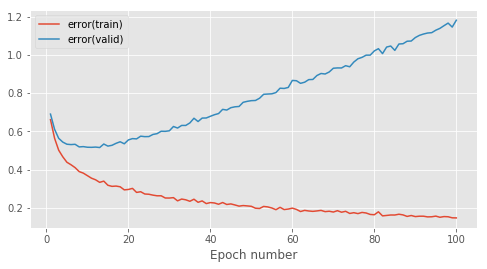

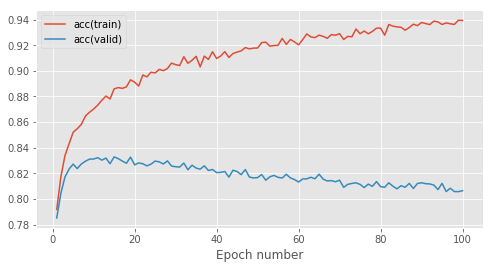

In [22]:
%load_ext autoreload
%autoreload 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 50
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate,)
experiment = 'Adam_Relu_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

### Batch normalisation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 6.2s to complete
    error(train)=7.08e-01, acc(train)=7.86e-01, error(valid)=7.30e-01, acc(valid)=7.78e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 4.7s to complete
    error(train)=5.96e-01, acc(train)=8.13e-01, error(valid)=6.32e-01, acc(valid)=8.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 5.1s to complete
    error(train)=5.39e-01, acc(train)=8.28e-01, error(valid)=5.85e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 4.9s to complete
    error(train)=5.07e-01, acc(train)=8.35e-01, error(valid)=5.63e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 4.5s to complete
    error(train)=4.85e-01, acc(train)=8.41e-01, error(valid)=5.51e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 5.3s to complete
    error(train)=4.65e-01, acc(train)=8.44e-01, error(valid)=5.37e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 4.3s to complete
    error(train)=4.43e-01, acc(train)=8.54e-01, error(valid)=5.21e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 4.2s to complete
    error(train)=4.30e-01, acc(train)=8.56e-01, error(valid)=5.18e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 4.2s to complete
    error(train)=4.25e-01, acc(train)=8.56e-01, error(valid)=5.15e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 4.6s to complete
    error(train)=4.05e-01, acc(train)=8.63e-01, error(valid)=5.06e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 4.2s to complete
    error(train)=4.06e-01, acc(train)=8.63e-01, error(valid)=5.09e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 4.1s to complete
    error(train)=3.90e-01, acc(train)=8.68e-01, error(valid)=5.01e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 4.2s to complete
    error(train)=3.82e-01, acc(train)=8.70e-01, error(valid)=4.98e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 4.5s to complete
    error(train)=3.80e-01, acc(train)=8.70e-01, error(valid)=4.98e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 4.4s to complete
    error(train)=3.75e-01, acc(train)=8.72e-01, error(valid)=5.00e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 4.3s to complete
    error(train)=3.69e-01, acc(train)=8.71e-01, error(valid)=4.95e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 4.2s to complete
    error(train)=3.55e-01, acc(train)=8.78e-01, error(valid)=4.90e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 4.4s to complete
    error(train)=3.54e-01, acc(train)=8.78e-01, error(valid)=4.90e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 4.0s to complete
    error(train)=3.50e-01, acc(train)=8.78e-01, error(valid)=4.94e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 5.2s to complete
    error(train)=3.44e-01, acc(train)=8.81e-01, error(valid)=4.90e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 4.7s to complete
    error(train)=3.41e-01, acc(train)=8.81e-01, error(valid)=4.88e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 5.0s to complete
    error(train)=3.35e-01, acc(train)=8.83e-01, error(valid)=4.89e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 4.7s to complete
    error(train)=3.35e-01, acc(train)=8.83e-01, error(valid)=4.93e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 4.9s to complete
    error(train)=3.26e-01, acc(train)=8.86e-01, error(valid)=4.90e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 4.7s to complete
    error(train)=3.24e-01, acc(train)=8.86e-01, error(valid)=4.87e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 4.0s to complete
    error(train)=3.17e-01, acc(train)=8.89e-01, error(valid)=4.84e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 4.2s to complete
    error(train)=3.15e-01, acc(train)=8.89e-01, error(valid)=4.85e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 4.5s to complete
    error(train)=3.14e-01, acc(train)=8.89e-01, error(valid)=4.93e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 5.0s to complete
    error(train)=3.11e-01, acc(train)=8.90e-01, error(valid)=4.91e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 4.5s to complete
    error(train)=3.05e-01, acc(train)=8.92e-01, error(valid)=4.90e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 4.6s to complete
    error(train)=3.05e-01, acc(train)=8.92e-01, error(valid)=4.87e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 5.1s to complete
    error(train)=3.03e-01, acc(train)=8.92e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 4.4s to complete
    error(train)=2.95e-01, acc(train)=8.94e-01, error(valid)=4.86e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 4.2s to complete
    error(train)=2.98e-01, acc(train)=8.94e-01, error(valid)=4.94e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 4.0s to complete
    error(train)=2.99e-01, acc(train)=8.93e-01, error(valid)=4.96e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 4.0s to complete
    error(train)=2.92e-01, acc(train)=8.96e-01, error(valid)=4.90e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 4.3s to complete
    error(train)=2.93e-01, acc(train)=8.95e-01, error(valid)=4.96e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 4.5s to complete
    error(train)=2.87e-01, acc(train)=8.98e-01, error(valid)=4.92e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 5.2s to complete
    error(train)=2.88e-01, acc(train)=8.96e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 4.9s to complete
    error(train)=2.87e-01, acc(train)=8.97e-01, error(valid)=5.04e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 3.8s to complete
    error(train)=2.82e-01, acc(train)=8.99e-01, error(valid)=4.95e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 4.5s to complete
    error(train)=2.83e-01, acc(train)=8.99e-01, error(valid)=5.02e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 3.8s to complete
    error(train)=2.77e-01, acc(train)=9.00e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 3.9s to complete
    error(train)=2.77e-01, acc(train)=9.00e-01, error(valid)=5.03e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 3.9s to complete
    error(train)=2.74e-01, acc(train)=9.01e-01, error(valid)=5.01e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 3.9s to complete
    error(train)=2.71e-01, acc(train)=9.02e-01, error(valid)=5.03e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 5.4s to complete
    error(train)=2.70e-01, acc(train)=9.03e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 4.9s to complete
    error(train)=2.67e-01, acc(train)=9.04e-01, error(valid)=5.05e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 6.4s to complete
    error(train)=2.67e-01, acc(train)=9.03e-01, error(valid)=5.06e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 5.4s to complete
    error(train)=2.68e-01, acc(train)=9.03e-01, error(valid)=5.03e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 4.4s to complete
    error(train)=2.60e-01, acc(train)=9.06e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 4.2s to complete
    error(train)=2.62e-01, acc(train)=9.04e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 4.3s to complete
    error(train)=2.60e-01, acc(train)=9.06e-01, error(valid)=5.08e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 5.1s to complete
    error(train)=2.59e-01, acc(train)=9.06e-01, error(valid)=5.11e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 4.6s to complete
    error(train)=2.61e-01, acc(train)=9.05e-01, error(valid)=5.14e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 4.5s to complete
    error(train)=2.56e-01, acc(train)=9.07e-01, error(valid)=5.13e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 4.2s to complete
    error(train)=2.54e-01, acc(train)=9.08e-01, error(valid)=5.16e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 4.5s to complete
    error(train)=2.55e-01, acc(train)=9.06e-01, error(valid)=5.23e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 4.4s to complete
    error(train)=2.53e-01, acc(train)=9.07e-01, error(valid)=5.18e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 4.7s to complete
    error(train)=2.52e-01, acc(train)=9.08e-01, error(valid)=5.22e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 4.1s to complete
    error(train)=2.53e-01, acc(train)=9.06e-01, error(valid)=5.23e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 4.4s to complete
    error(train)=2.50e-01, acc(train)=9.09e-01, error(valid)=5.21e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 4.1s to complete
    error(train)=2.49e-01, acc(train)=9.09e-01, error(valid)=5.24e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 4.2s to complete
    error(train)=2.50e-01, acc(train)=9.08e-01, error(valid)=5.30e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 5.1s to complete
    error(train)=2.43e-01, acc(train)=9.11e-01, error(valid)=5.25e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 5.2s to complete
    error(train)=2.44e-01, acc(train)=9.11e-01, error(valid)=5.32e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 4.7s to complete
    error(train)=2.47e-01, acc(train)=9.10e-01, error(valid)=5.30e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 4.8s to complete
    error(train)=2.44e-01, acc(train)=9.11e-01, error(valid)=5.30e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 4.7s to complete
    error(train)=2.42e-01, acc(train)=9.12e-01, error(valid)=5.32e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 4.9s to complete
    error(train)=2.38e-01, acc(train)=9.12e-01, error(valid)=5.30e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 4.6s to complete
    error(train)=2.42e-01, acc(train)=9.11e-01, error(valid)=5.42e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 4.9s to complete
    error(train)=2.36e-01, acc(train)=9.13e-01, error(valid)=5.36e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 5.2s to complete
    error(train)=2.39e-01, acc(train)=9.11e-01, error(valid)=5.33e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 5.2s to complete
    error(train)=2.38e-01, acc(train)=9.12e-01, error(valid)=5.35e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 5.3s to complete
    error(train)=2.36e-01, acc(train)=9.12e-01, error(valid)=5.37e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 5.1s to complete
    error(train)=2.33e-01, acc(train)=9.14e-01, error(valid)=5.41e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 5.0s to complete
    error(train)=2.33e-01, acc(train)=9.14e-01, error(valid)=5.33e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 5.5s to complete
    error(train)=2.33e-01, acc(train)=9.13e-01, error(valid)=5.38e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 4.4s to complete
    error(train)=2.31e-01, acc(train)=9.14e-01, error(valid)=5.42e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 4.9s to complete
    error(train)=2.32e-01, acc(train)=9.15e-01, error(valid)=5.44e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 5.5s to complete
    error(train)=2.32e-01, acc(train)=9.14e-01, error(valid)=5.43e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 4.0s to complete
    error(train)=2.28e-01, acc(train)=9.17e-01, error(valid)=5.42e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 4.8s to complete
    error(train)=2.24e-01, acc(train)=9.17e-01, error(valid)=5.44e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 4.7s to complete
    error(train)=2.22e-01, acc(train)=9.18e-01, error(valid)=5.44e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 4.5s to complete
    error(train)=2.22e-01, acc(train)=9.18e-01, error(valid)=5.46e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 4.2s to complete
    error(train)=2.24e-01, acc(train)=9.18e-01, error(valid)=5.55e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 4.1s to complete
    error(train)=2.21e-01, acc(train)=9.19e-01, error(valid)=5.50e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 4.3s to complete
    error(train)=2.24e-01, acc(train)=9.16e-01, error(valid)=5.51e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 4.4s to complete
    error(train)=2.18e-01, acc(train)=9.20e-01, error(valid)=5.50e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 4.2s to complete
    error(train)=2.20e-01, acc(train)=9.19e-01, error(valid)=5.58e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 5.8s to complete
    error(train)=2.22e-01, acc(train)=9.17e-01, error(valid)=5.63e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 5.6s to complete
    error(train)=2.20e-01, acc(train)=9.19e-01, error(valid)=5.58e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 4.7s to complete
    error(train)=2.15e-01, acc(train)=9.21e-01, error(valid)=5.60e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 4.6s to complete
    error(train)=2.18e-01, acc(train)=9.19e-01, error(valid)=5.61e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 4.9s to complete
    error(train)=2.14e-01, acc(train)=9.21e-01, error(valid)=5.59e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 4.0s to complete
    error(train)=2.15e-01, acc(train)=9.19e-01, error(valid)=5.64e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 7.4s to complete
    error(train)=2.14e-01, acc(train)=9.21e-01, error(valid)=5.66e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 5.8s to complete
    error(train)=2.13e-01, acc(train)=9.21e-01, error(valid)=5.60e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 5.3s to complete
    error(train)=2.12e-01, acc(train)=9.22e-01, error(valid)=5.67e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 6.0s to complete
    error(train)=2.14e-01, acc(train)=9.21e-01, error(valid)=5.63e-01, acc(valid)=8.30e-01



Best acc at Epoch=26 by learning_rate=0.001
error(train)= 0.3165519869526008, error(valid)=0.4839970683766283, 
                             error gap = 0.16744508142402753,  acc(valid)=0.8422151898734177
Smallest error gap(after best acc epoch) = 0.16744508142402753 at Epoch=26


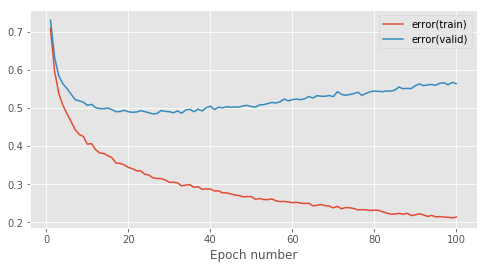

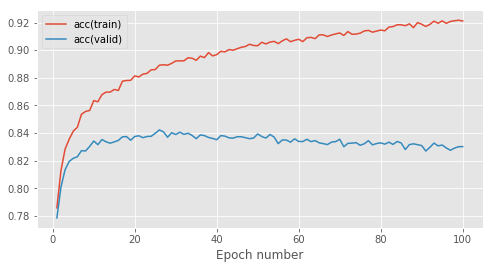

In [9]:
%load_ext autoreload
%autoreload 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate,)

experiment = 'BatchNorm_Relu_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

### Batch normalisation with Dropout
Hidden units scaled with 1./incl_prob  
Set Adam learning rule's beta1 = 0.99

In [ ]:
%load_ext autoreload
%autoreload 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import RMSPropLearningRule, AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256
##########################################################
# Use p = 0.5 in hidden layers and 0.8 in the input layer.
incl_prob_0 =0.8
incl_prob = 0.5
# n/p
hidden_dim = int(hidden_dim/incl_prob)
mom_coeff = 0.99
##########################################################
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate, beta1=mom_coeff)

experiment = 'BatchNorm_drop_Relu_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

### Plot the data


D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


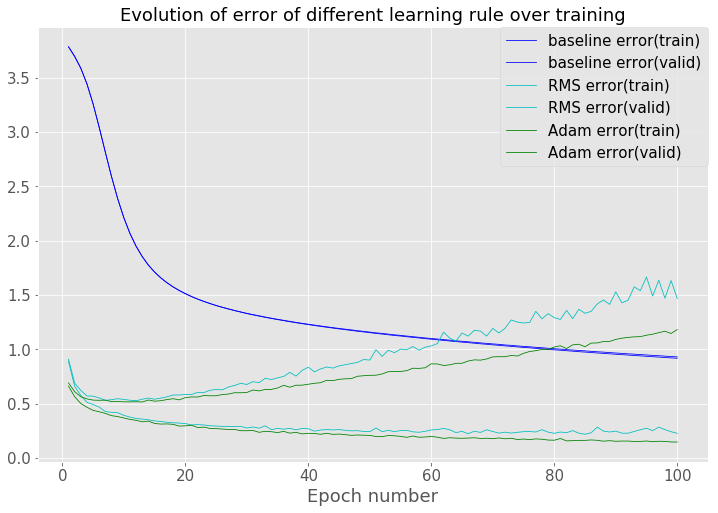

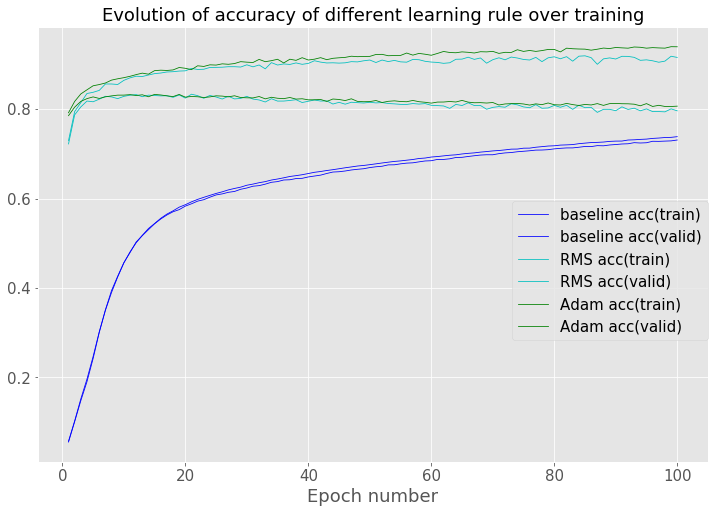

In [27]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

# Plot the change in the validation and training set error over training.
fig_1_comp = plt.figure(figsize=(12 , 8))
color = ['b', 'c','g', 'r', 'y']

plot_list = [stats, stats_rms, stats_adam]
plot_list_name = ['baseline','RMS','Adam']
ax_1 = fig_1_comp.add_subplot(111)

for i,s in enumerate(plot_list):#,stats_ELU_4,stats_ELU_5,stats_ELU_6,stats_ELU_7,stats_ELU_8]:
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval, 
              s[1:, keys[k]], label=str(plot_list_name[i]+' '+k),color=color[i],linewidth=0.8)

ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Evolution of error of different learning rule over training',fontsize=18)

# Plot the change in the validation and training set accuracy over training.
fig_2_comp = plt.figure(figsize=(12, 8))
ax_2 = fig_2_comp.add_subplot(111)
for i,s in enumerate(plot_list):
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval, 
              s[1:, keys[k]], label=str(plot_list_name[i]+' '+k),color=color[i],linewidth=0.8)
ax_2.legend(bbox_to_anchor=(1., 0.6), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Evolution of accuracy of different learning rule over training',fontsize=18)

fig_1_comp.savefig('error_comp_learningrule.pdf',bbox_inches = "tight")
fig_2_comp.savefig('accuracy_comp_learningrule.pdf',bbox_inches = "tight" )